<div style="border: 1px solid #CCCCFF; border-radius: 1px;">
<div style="margin: 5px">
<b class="alert-heading">Комментарий ревьюера</b>
<p>Алексей, привет!</p>
<p>Меня зовут Алексей Секоцкий. Поздравляю с подготовкой очередного проекта. Предлагаю обращаться друг к другу на «ты» если нет возражений. Ниже стандартный блок с условными обозначениями:</p>
<div class="alert alert-success" role="alert">
всё отлично
</div>
<div class="alert alert-warning" role="alert">
рекомендации на будущее (не требующие доработки проекта)
</div>
<div class="alert alert-danger" role="alert">
критичные моменты требующие внимания (доработки)
</div>
<div class="alert alert-info">
информационные комментарии и итоговый
</div>

<hr>
<p>Пожалуйста, не изменяй и не удаляй мои комментарии – они потребуются для повторной проверки (при необходимости). Задавай вопросы и описывай сделанные изменения, помечая их любым удобным наглядным способом.</p>

# Определение возраста покупателей

Описание проекта    
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:    

__Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;__
   
__Контролировать добросовестность кассиров при продаже алкоголя.__   
   
Построим модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.   



# Оглавление <a name="4"></a>

1  [Исследовательский анализ данных](#1)

1-1 [Вывод по исследовательскому анализу данных](#2)

2  [Обучение модели](#3)

3 [Анализ обученной модели](#5)

## Исследовательский анализ данных <a name="1"></a>

<div class="alert alert-warning">
<b>Комментарий ревьюера</b>

Перед отправкой ноутбука на проверку (или сдачей заказчику) рекомендую перезапускать код. Это позволит удостовериться в правильности выполнения всех ячеек.
</div>

In [18]:
# Импотрируем сразу нужные библиотеки
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
#Запустим и распакуем датасет
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [25]:
#посмотрим на датасет
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [26]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Text(0.5, 1.0, 'Распределения возраста')

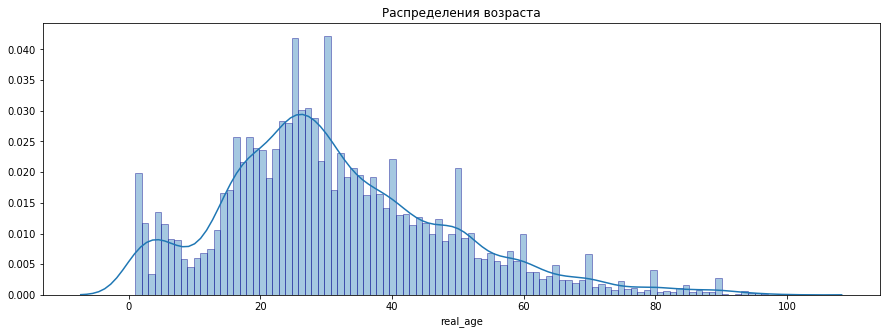

In [27]:
#Построим график распредления возраста
fig = plt.figure(figsize=(15,5))
sns.distplot(labels.real_age, kde = True,  bins=labels.real_age.max(),hist_kws={'edgecolor':'darkblue'}).set_title('Распределения возраста')

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Хороший график. Корзин достаточно. Важно обратить внимание на пики на кругдые даты.
</div>

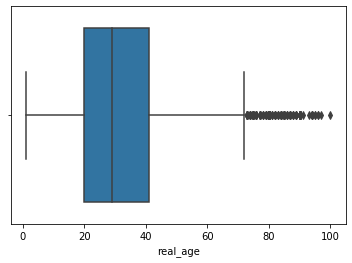

In [29]:
sns.boxplot(labels["real_age"])

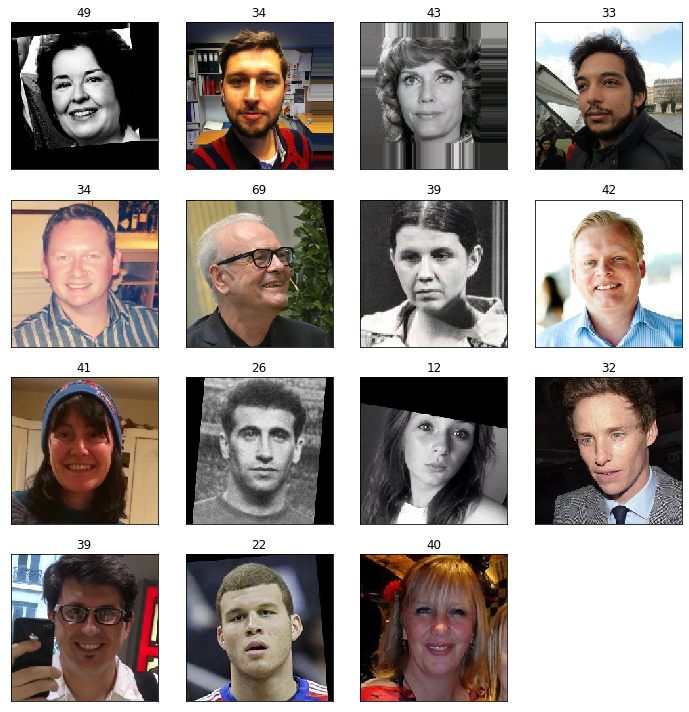

In [30]:
#Выберем 15 фото из  выборки и посмотрим на них
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(target[i])
    plt.tight_layout()


# Выводы по исследовательскому анализу данных  <a name="2"></a>

Мы имеем 7591 изображений.
Возраст распределен нормально со скошенностью вправо.
Много фотографий детей до 10 лет.
Больше всего фотографий людей возраста 25-30 лет. 
Чаще всего встречается возраст от 20 лет до 41 года.
Мало фотографий людей от 60 лет, поэтому модель может плохо определять старший возраст.
Аномальный возраст - 88 лет и более. 
Есть цветные и черно-белые фотографии. 
Фотографии людей представлены в разных ракурсах: анфас, в полоборота, в профиль.
Есть фотографии, которые имеют наклон или смещение.
Будем использовать горизонтальное отражение фотографии для аугментации.

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Отличное описание фото. На гистограмме важно обратить внимание на пики и выдвинуть предоположение откуда они могли появиться. Также добавить размер нашего датасета достаточный или нет для обучения.
</div>

[Назад в оглавление](#4)

# Обучение модели  <a name="3"></a>

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Отлично, что есть аугментация. Можно использовать другие виды, примеры можно посмотреть в <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator">документации</a>.
</div>

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

Train for 356 steps, validate for 119 steps
Epoch 1/10
2021-07-05 08:18:25.678575: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-07-05 08:18:25.980254: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 46s - loss: 227.7920 - mae: 11.0002 - val_loss: 538.5904 - val_mae: 18.1383
Epoch 2/10
356/356 - 38s - loss: 84.2288 - mae: 6.9846 - val_loss: 119.3393 - val_mae: 8.3704
Epoch 3/10
356/356 - 38s - loss: 59.0670 - mae: 5.8585 - val_loss: 108.6068 - val_mae: 8.1699
Epoch 4/10
356/356 - 37s - loss: 43.3577 - mae: 5.0417 - val_loss: 94.6977 - val_mae: 7.1303
Epoch 5/10
356/356 - 37s - loss: 33.9467 - mae: 4.4257 - val_loss: 96.3746 - val_mae: 7.4567
Epoch 6/10
356/356 - 38s - loss: 27.2489 - mae: 4.0114 - val_loss: 78.2131 - val_mae: 6.4633
Epoch 7/10
356/356 - 38s - loss: 22.8295 - mae: 3.6601 - val_loss: 73.2815 - val_mae: 6.4766
Epoch 8/10
356/356 - 38s - loss: 17.5367 - mae: 3.1851 - val_loss: 93.9922 - val_mae: 7.5177
Epoch 9/10
356/356 - 37s - loss: 13.7527 - mae: 2.8320 - val_loss: 71.6863 - val_mae: 6.4398
Epoch 10/10
356/356 - 37s - loss: 11.8659 - mae: 2.6167 - val_loss: 67.3922 - val_mae: 6.2084
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 67.3922 - mae: 6.2084
Test MAE: 6.2084
```

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Отличная метрика для 10 эпох. Важно обратить внимание на склонность модели к переобучению.
</div>

# 3 Анализ обученной модели <a name="5"></a>

С помощью модели ResNet50 мы получили приемлымый результат.   
Использовались предобученные веса, что ускорило обучение. 
Использовался слой пулинга GlobalAveragePooling2D для усреднения информации по всему изображению, т.е. получить пиксель с большим количеством каналов и в выходном слое один нейрон, так как нам в конце нужно получить одно число - возраст. 
Использовалась функция активации ReLU, чтобы отрицательные результаты привести к 0. 
В качестве аугментации было применено только horizontal_flip, которое не привело к искажению данных, при чем в датасете уже были данные со смотрящими в разные стороны людьми. Сдвиг и отзеркаливание вертикально не применяли, т.к. это привело бы к искажению данных.

<div class="alert alert-success">
<b>Комментарий ревьюера</b>

Верный подробный вывод. Отлично, что расписаны все особенности модели и подробное описание аугментации. Небольшие сдвиги и наклоны изображений не навредили бы нашей задаче, хотя метрика могла немного ухудшиться. Однако в реальной задаче лица будут попадать не обязательно в центр камеры и под разными наклонами головы (10-15 градусов).
</div>

<div class="alert alert-info">
<b>Итоговый комментарий ревьюера</b>

Поздравляю с успешной подготовкой проекта. Все шаги выполнены. Отличные комментарии и выводы. Верные подходы к обучению модели и подробное описание ее работы. Данная тема достаточно обширная для одного спринта. Наша задача понять основы, которые при необходимости позволят погрузиться в нее без особых трудностей. Рекомендую ознакомиться с фреймворком <a href="https://pytorch.org/">PyTorch</a>. Желаю успехов в финальном спринте и профессии!

<hr>
</div>

[Назад в оглавление](#4)

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы